In [8]:
# This example is an application for a simple Bayesian linear regression model to propose how to use pymc modulus to fulfill
# link: https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html

import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [14]:
"""
The predicted outcome (Y: observed data ) assuming from normal-distribution prior with expected mu can be estimated by the following linear equation:
                        Y ~ N(mu,std^2)
There is a linear regression modeling for mu with three coefficient (a0: intercept; b1, b2: for X1 X2)                        
                        mu = a0 + b1 * X1 + b2 * X2
                        
Assume we don't know the distributions of coefficient, mu, and std, we assign the weakly infomative prior to the testing coefficient and the paramter.

                        a0 ~ N(0,100) (std = 10)
                        bi ~ N(0,100)
                        std ~ |N(0,1)|
"""

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma


Text(0.5, 0, 'X2')

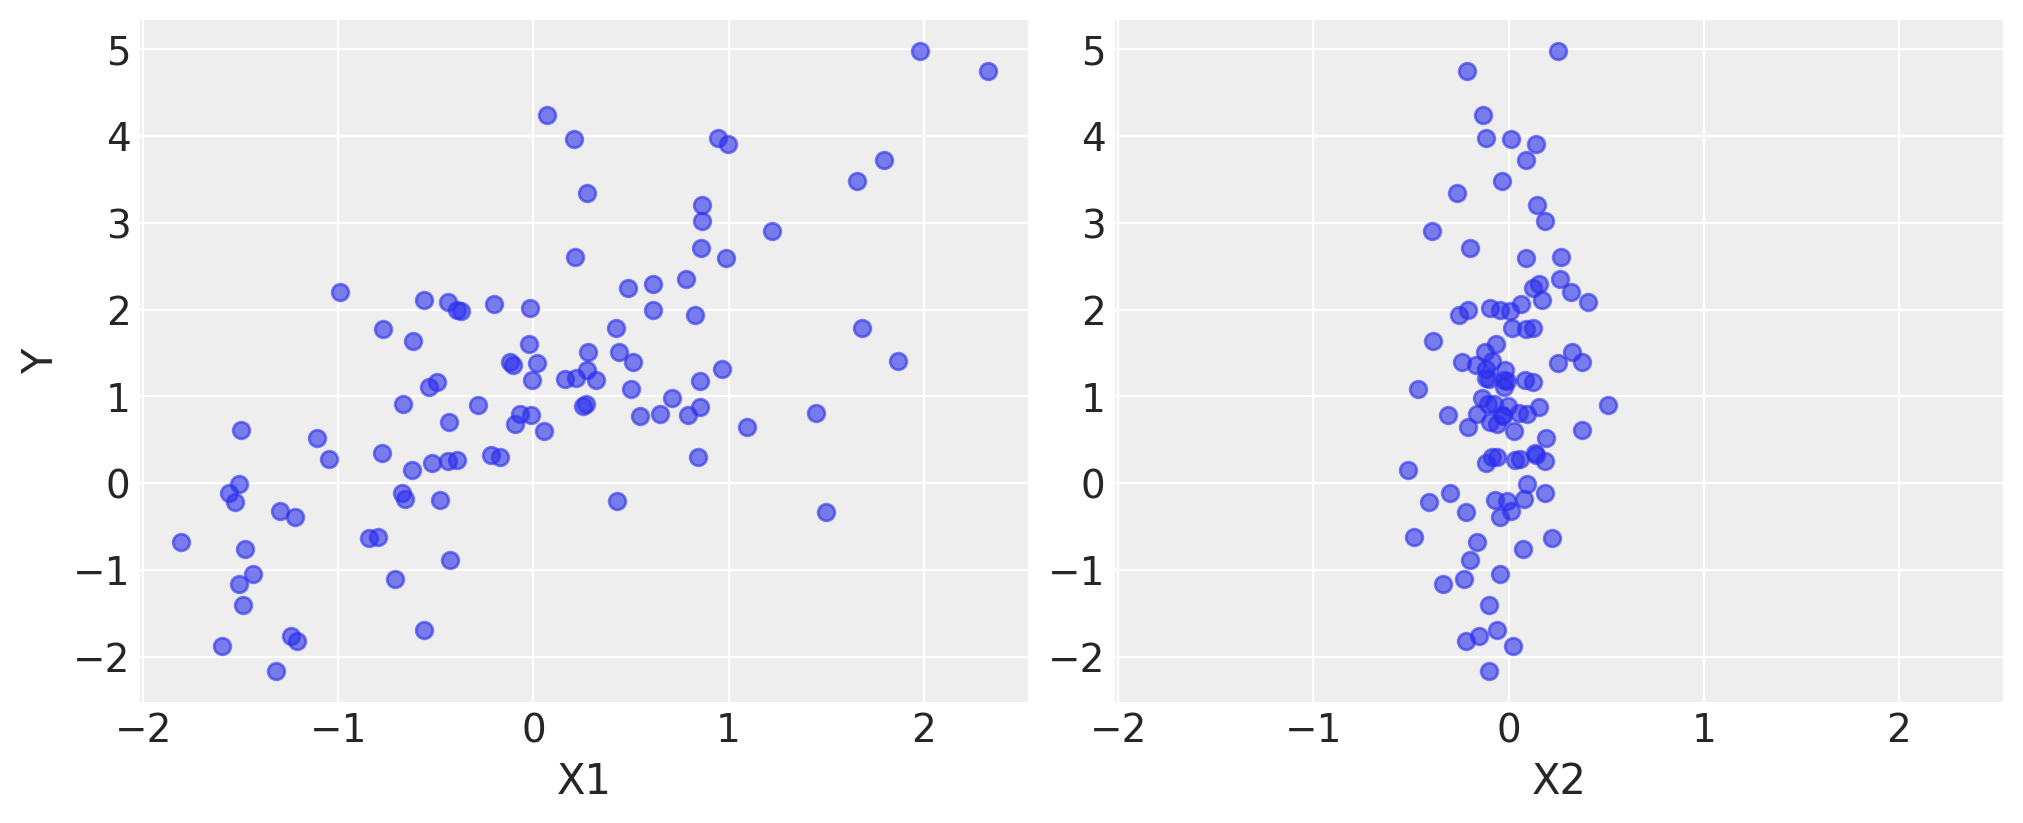

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [16]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.0


In [17]:
# Create a model which is a container for the model random variables
basic_model = pm.Model()

with basic_model: # All pymc object introduced in indented code block below the 'with' statement (i.e. alpha)are add to the model behind the scene. (basic_model)
    # Priors for unknown model parameters
    # Create a random variable to use as a normal prior
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2) # because we have two coefficients to calibate, the shape of a normal distribution will be given to 2
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Create the expected values of mu by specifying the linear relationship
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)


In [13]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()
    
    """
        The sample will return an InferenceData object containing the sample collected
        Reference for InferenceData :https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.html#arviz.InferenceData  
    """

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


In [32]:
idata

KeyboardInterrupt: 

In [31]:
idata.posterior["sigma"].sel(draw=slice(1, 10))

KeyboardInterrupt: 

In [29]:
with basic_model:
    # instantiate sampler
    # Using Slice Sampling Algroithms to sample our parameter
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 435 seconds.


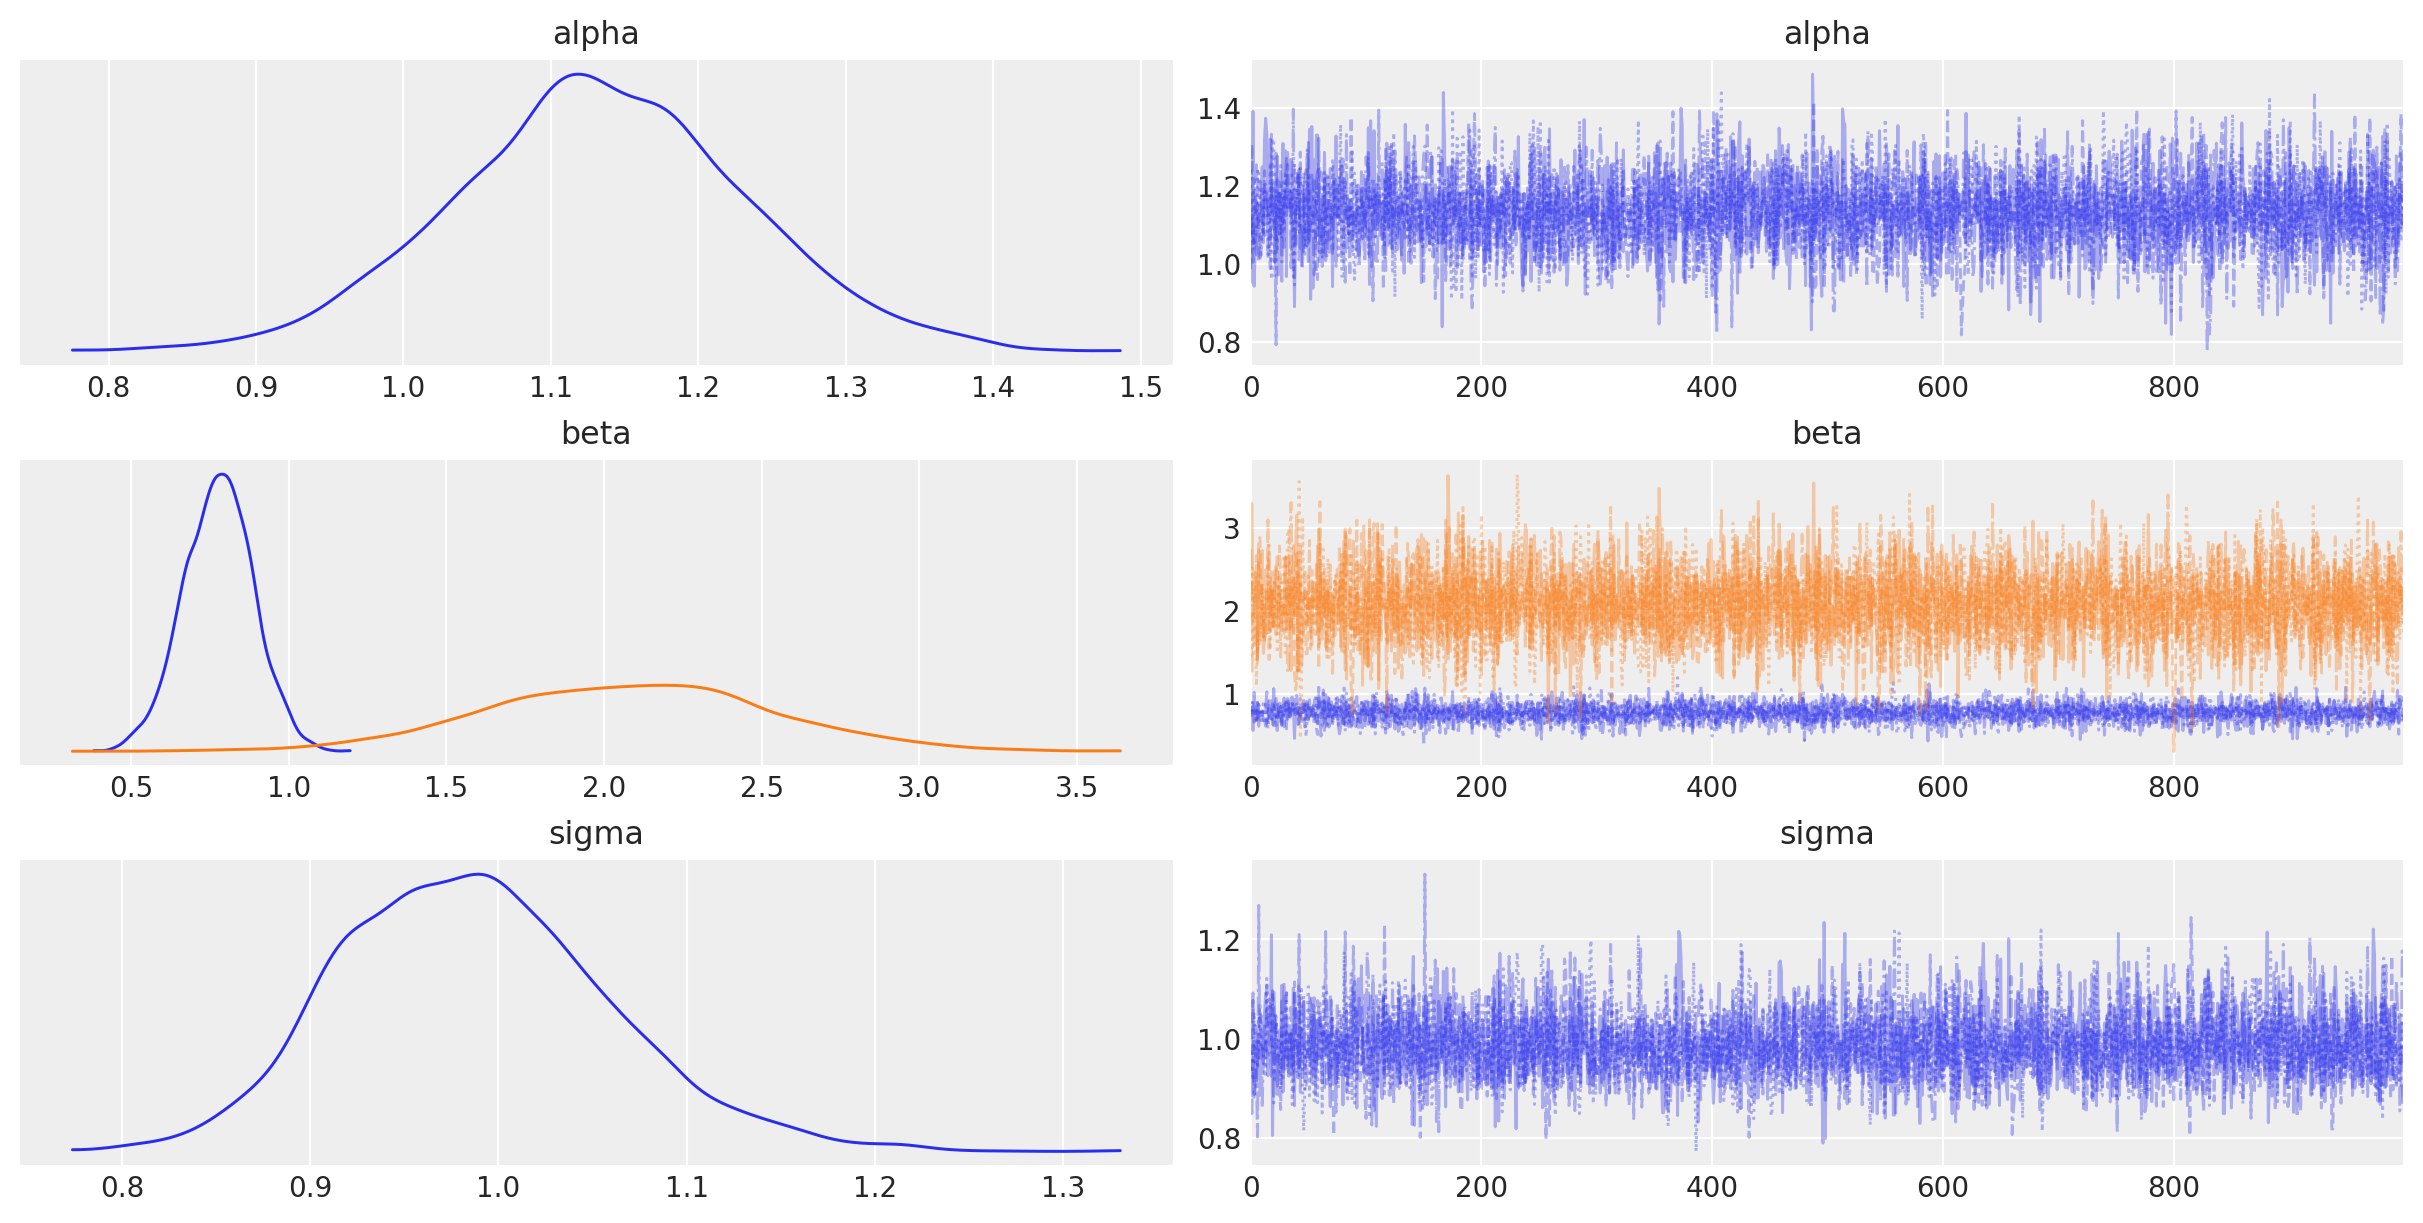

In [34]:
az.plot_trace(idata, combined=True);